In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')

In [2]:
# speed test
speedtest = pd.read_csv('/media/caozhichongchong/baf7fe39-6567-421c-a79a-4c274b89f9f7/scripts/snp_curate/SNP_model_parallel_new/alltime.txt',
                    sep='\t',index_col = False)
speedtest['tool'] = [x.replace('minimap','minimap2').replace('bowtie','bowtie2') for x in speedtest['tool']]
speedtest.head()

,genome,tool,thread,real time,time
0,all,mapper,1,14m25.102s,865.102
1,all,mapper,3,5m8.757s,308.757
2,all,mapper,5,3m23.972s,203.972
3,all,mapper,7,2m24.309s,144.309
4,all,mapper,9,2m0.625s,120.625


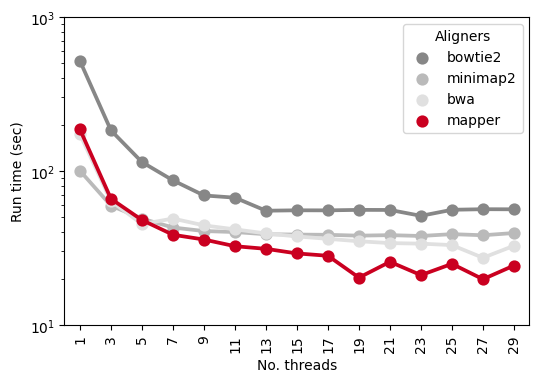

In [3]:
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
        'bowtie2 (15mer)':'#0571b0','minimap2 (10mer)':'#92c5de',
    'mapper (no ancestor)':'#ca0020','mapper (12mer)':'#ca0020','mapper (18mer)':'#ca0020','mapper (24mer)':'#ca0020'}

legend_order = [ 'bowtie2', 'minimap2',
                'bwa', 
                'mapper']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6,4))
# sns.lineplot(data = speedtest[speedtest['genome']=='am_BaFr_g0050'],
#             x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
sns.pointplot(data = speedtest[speedtest['genome']=='am_BaFr_g0050'],
            x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('No. threads') 
axs.set_ylabel('Run time (sec)')

axs.set(yscale="log")
axs.set_yticks([10, 100, 1000])

plt.sca(axs)
plt.xticks(rotation=90)

plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('am_BaFr_g0050_genome_speed_test.pdf',bbox_inches='tight')


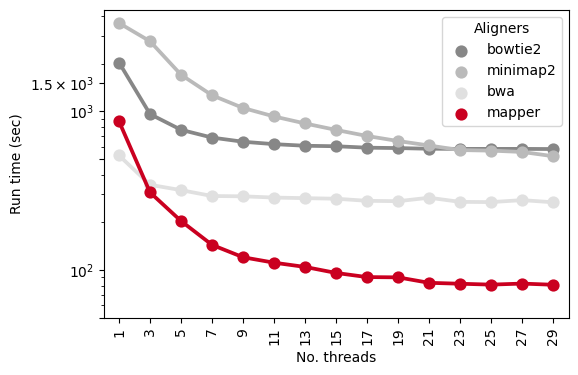

In [4]:
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
        'bowtie2 (15mer)':'#0571b0','minimap2 (10mer)':'#92c5de',
    'mapper (no ancestor)':'#ca0020','mapper (12mer)':'#ca0020','mapper (18mer)':'#ca0020','mapper (24mer)':'#ca0020'}

legend_order = [ 'bowtie2', 'minimap2',
                'bwa', 
                'mapper']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6,4))
# sns.lineplot(data = speedtest[speedtest['genome']=='all'],
#             x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
sns.pointplot(data = speedtest[speedtest['genome']=='all'],
            x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('No. threads') 
axs.set_ylabel('Run time (sec)')
axs.set(yscale="log")
axs.set_yticks([50, 100, 500,1000,1500])
plt.sca(axs)
plt.xticks(rotation=90)

plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('all_genome_speed_test.pdf',bbox_inches='tight')


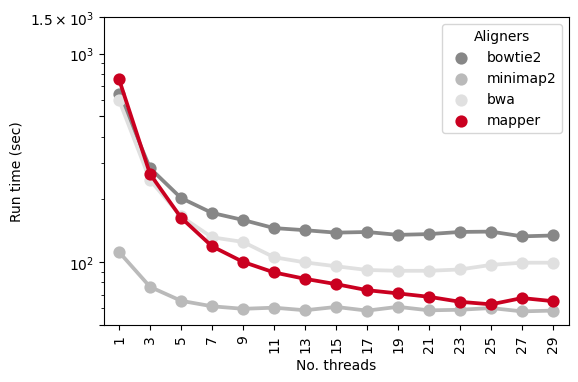

In [5]:
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
        'bowtie2 (15mer)':'#0571b0','minimap2 (10mer)':'#92c5de',
    'mapper (no ancestor)':'#ca0020','mapper (12mer)':'#ca0020','mapper (18mer)':'#ca0020','mapper (24mer)':'#ca0020'}

legend_order = [ 'bowtie2', 'minimap2',
                'bwa', 
                'mapper']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6,4))
# sns.lineplot(data = speedtest[speedtest['genome']=='all'],
#             x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
sns.pointplot(data = speedtest[speedtest['genome']=='am0230'],
            x='thread',y='time',hue='tool',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('No. threads') 
axs.set_ylabel('Run time (sec)')
axs.set(yscale="log")
axs.set_yticks([50, 100, 500,1000,1500])
plt.sca(axs)
plt.xticks(rotation=90)

plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('am0230_genome_speed_test.pdf',bbox_inches='tight')


In [171]:
# load sams

import glob
import os
from Bio import SeqIO
from Bio.Seq import Seq
import argparse
import re
from multiprocessing import Process
from multiprocessing import Queue
from itertools import islice
from datetime import datetime
import psutil

samplenameset = ['am0230','am_PaDi_g0001']# 'am_PaDi_g0001'#'Bactor'#'am0230'
toolset = {
    'mapper1':0,
    'bowtie':1,
    'bwa':2,
    'minimap':3,
        'mapper1.kmer12':4,
        'mapper1.kmer14':5,
    'mapper1.kmer16':6,
     'mapper1.kmer18':7,
        'mapper1.kmer20':8,
    'mapper1.kmer22':9,
 'mapper1.kmer24':10,
}
penalty_set = ['mapper','bowtie','bwa','minimap']
max_penalty_set = {
    
    'mapper':0.1,
    'bowtie':0.6,
    'bwa':0.5,
    'minimap':0.6,
}

soft_clip_middle_penalty = 500
max_score = 1000
penalty_setscore = {
    'bowtie':[6,5,3,0,1],
    'minimap':[6,4,2,0,1],
    'bwa':[5,6,1,0,1],
    'mapper':[1,2,0.5,0,0.1]
}


def ref_read_chopbyCIGAR(readID, read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N):
    # read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N
    if CIGAR == '*':
        return max_score
    CIGARlenset = re.split('S|D|M|I|N|H|P', CIGAR)[:-1]
    i = 0
    kread = 0
    kref = 0
    readset = []
    refset = []
    penalty = 0
    #print('start',read,ref,CIGAR,CIGARlenset)
    CIGARlocus = 0
    for CIGARlen in CIGARlenset:
        i += len(CIGARlen)
        CIGARtype = CIGAR[i]
        #print('process CIGAR',CIGARtype,CIGARlen)
        i += 1
        if CIGARtype == 'M':
            # matches
            readset += read[kread:(kread + int(CIGARlen))]
            refset += ref[kref:(kref + int(CIGARlen))]
            kread += int(CIGARlen)
            kref += int(CIGARlen)
            # print('M',penalty,kread,kref,''.join(readset),''.join(refset))
        elif CIGARtype == 'S' or CIGARtype == 'H':
            # clipping in read treat as ambiguous matches
            if treat_soft_clip_as_N:
                kread += int(CIGARlen)
                penalty += int(CIGARlen) * n_penalty
                # print('S', penalty,kread, kref)
            else:
                # insertion in read, no longer treated as ambiguous matches (because other tools do not)
                # what if the ref has all Ns at soft clipping regions?
                kread += int(CIGARlen)
                penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty + soft_clip_middle_penalty # + int(CIGARlen)*n_penalty
                read_with_softclips_in_middle_read.add(readID)
                # print('S->I', penalty, kread, kref)
        elif CIGARtype == 'I':
            # insertion in read, no longer treated as ambiguous matches (because other tools do not), because we can't verify that they match what was in the reference (because the reference had nothing there)
            kread += int(CIGARlen)
            penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty  # + int(CIGARlen)*n_penalty
            # print('I', penalty,kread, kref)
        elif CIGARtype == 'D':
            # insertion in ref
            kref += int(CIGARlen)
            penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty
            #print('D', penalty,kread, kref)
        elif CIGARtype == 'N':
            # skipped region from the reference
            kref += int(CIGARlen)
            penalty += int(CIGARlen)*n_penalty
            #print('N', penalty,kread, kref)
        elif CIGARtype == 'P':
            # hard clipping or padding
            pass
        CIGARlocus += 1
    return mismatch_check(readset,refset,penalty)

def load_ref(database):
    Ref = dict()
    for record in SeqIO.parse(database, 'fasta'):
        Ref.setdefault(str(record.id),str(record.seq))
    return Ref

def is_read_reverse_strand(flag):
    return bool(flag & 16)

def is_supplementary_alignment(flag):
    return bool(flag & 2048)

def mismatch_check(readset,refset,penalty):
    totallen = min(len(readset),len(refset))
    mismatch = 0
    nDNA = 0
    for i in range(0,totallen):
        if refset[i] == 'N' or readset[i]=='N':
            nDNA += 1
        elif readset[i] != refset[i]:
            mismatch += 1
    #print('total pennlty=',penalty+mismatch*mismatch_penalty + nDNA*n_penalty,'mismatch = ',mismatch,'nDNA=',nDNA)
    #print(penalty,mismatch,nDNA)
    final_penalty = (penalty + mismatch*mismatch_penalty + nDNA*n_penalty + (totallen-mismatch-nDNA)*match_penalty)
    #print('final penalty=',final_penalty,totallen,(totallen-mismatch-nDNA)*match_penalty)
    return final_penalty

def add_tag_tool(toolscore,toolCHRPOS,bestCHRPOS,bestscore):
    if bestscore == toolscore:
        return 'bestalignment'
    if max_score == toolscore:
        return 'alignmentmissed'
    toolCHR, toolPOS = toolCHRPOS.split('\t')
    try:
        bestCHR, bestPOS = bestCHRPOS.split('\t')
    except ValueError:
        print(toolscore,toolCHRPOS,bestCHRPOS,bestscore)
        return 'badalignment' # caused by S
    if toolCHR != bestCHR:
        return 'diffCHR'
    else:
        bestPOS = int(bestPOS)
        toolPOS = int(toolPOS)
        if bestPOS == toolPOS:
            return 'sameCHRsamePOS'
        elif toolPOS <= bestPOS + 100 and toolPOS >= bestPOS - 100:
            return 'sameCHRclosePOS'
        else:
            return 'sameCHRdiffPOS'

def add_tag(newscore,allCIGAR,allCHRPOS):
    tag2 = ''
    bestscore = min(newscore)
    besttool = newscore.index(bestscore)
    bestCIGAR = allCIGAR[besttool]
    bestCHRPOS = allCHRPOS[besttool]
    worstscore = max(newscore)
    worsttool = newscore.index(worstscore)
    worstCIGAR = allCIGAR[worsttool]
    if 'S' in bestCIGAR:
        tag2 += 'RightSoft'
    if 'I' in bestCIGAR or 'D' in bestCIGAR:
        tag2 += 'RightIn'
    if 'S' in worstCIGAR:
        tag2 += 'WrongSoft'
    if 'I' in worstCIGAR or 'D' in worstCIGAR:
        tag2 += 'WrongIn'
    if tag2 == '' and 'H' not in worstCIGAR and 'H' not in bestCIGAR and bestscore >= mismatch_penalty*5:
        tag2 += '>=5 SNPs'
    tagtool = []
    for i in range(0,len(newscore)):
        tagtool.append(add_tag_tool(newscore[i],allCHRPOS[i],bestCHRPOS,bestscore))
    return [tagtool,tag2,bestscore]

for samplename in samplenameset:
    allref = glob.glob('test_data/penalty_test/%s*.fasta' % (samplename[:3]))[0]
    print(allref)
    Ref = load_ref(allref)
    for penaltyname in penalty_set:
#         if penaltyname == 'mapper' and samplename == 'am0230':
#             pass
#         else:
            penaltylist = dict()
            read_with_softclips_in_middle_read = set()
            max_penalty = max_penalty_set[penaltyname]
            mismatch_penalty, gapopen_penalty, gapextend_penalty, match_penalty, n_penalty = penalty_setscore[penaltyname]
            print(penaltyname, mismatch_penalty, gapopen_penalty, gapextend_penalty, match_penalty, n_penalty,max_penalty)
            for tool in toolset:
                sam = 'SNP_model_penalty/%s/%s_all.fastq_%s.fasta.%s.sam'%(penaltyname,samplename,samplename,tool)
                print(sam)
                position = toolset[tool]
                for lines in open(sam,'r'):
                    if not lines.startswith('@'):
                            lines_set = lines.split('\n')[0].split('\t')
                            CHR, POS = lines_set[2:4]
                            FLAG = int(lines_set[1])
                            read = lines_set[9]
                            read_reverse = str(Seq(read).reverse_complement())
                            if is_read_reverse_strand(FLAG):
                                readID = lines_set[0] +'\t'+ read_reverse
                            else:
                                readID = lines_set[0] + '\t' + read
                            CHR = CHR.split(' ')[0]
                            penaltylist.setdefault(readID,[
                                                   [max_score]*len(toolset),
                                ['']*len(toolset),['']*len(toolset),len(read)
                            ]
                                                  )
                            if CHR != '*' and not is_supplementary_alignment(FLAG):
                                CHRPOS = '%s\t%s'%(CHR,POS)
                                # read matches somewhere
                                CIGAR = lines_set[5]
                                reflen = len(Ref[CHR])
                                readlen = len(read)
                                POS = int(POS)
                                POSend = POS + readlen
                                treat_soft_clip_as_N = False
                                if POS <= 1 or POSend >= reflen:
                                    # possible soft clip when it's the end of the read
                                    treat_soft_clip_as_N = True
                                ref = Ref[CHR][(POS - 1):min(POSend, reflen)]
                                penalty = ref_read_chopbyCIGAR(readID,read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N)
                                previous_penalty = penaltylist[readID][0][position]
                                if previous_penalty > penalty:
                                    penaltylist[readID][0][position] = penalty
                                    penaltylist[readID][1][position] = CIGAR
                                    penaltylist[readID][2][position] = CHRPOS
        #                         if lines_set[0] == '700536:HVGGKBCXX161014:HVGGKBCXX:2:2104:1409:73868':
        #                             print(treat_soft_clip_as_N,lines_set[0])
        #                             print(read)
        #                             print(ref)
        #                             print(CIGAR)
        #                             print(penalty,previous_penalty)
        #                             break
        #                         if lines_set[0] == '700536:HVG5YBCXX161014:HVG5YBCXX:1:1111:21061:26681':
        #                             print(treat_soft_clip_as_N,lines_set[0])
        #                             break
        #     print(len(penaltylist))
        #     print(penaltylist[readID])
            newresult = ['readID\tread\t%s\t%s\ttag2\tminpenalty\n'%('\t'.join(
            [x.replace('mapper1','mapper') for x in toolset]),'\t'.join(
            ['tag'+ x.replace('mapper1','mapper') for x in toolset])
            )]
            newresult_clean = ['readID\tread\t%s\t%s\ttag2\tminpenalty\n'%('\t'.join(
            [x.replace('mapper1','mapper') for x in toolset]),'\t'.join(
            ['tag'+ x.replace('mapper1','mapper') for x in toolset])
            )]
            for readID in penaltylist:
                newscore,allCIGAR,allCHRPOS,readlen = penaltylist[readID]
                tagtool, tagtotal,bestscore = add_tag(newscore,allCIGAR,allCHRPOS)
                limitpenalty = readlen * max_penalty
                if min(newscore[0:4]) <= limitpenalty:
                    newresult.append('%s\t%s\t%s\t%s\t%s\n'%(
                    readID,'\t'.join([str(x) for x in newscore]),'\t'.join(tagtool),tagtotal,bestscore
                    ))
                    if readID not in read_with_softclips_in_middle_read:
                        newresult_clean.append('%s\t%s\t%s\t%s\t%s\n'%(
                    readID,'\t'.join([str(x) for x in newscore]),'\t'.join(tagtool),tagtotal,bestscore
                    ))
        #         if '700536:HVG5YBCXX161014:HVG5YBCXX:2:2203:7765:49191' in readID:
        #             print(newscore,allCIGAR,allCHRPOS,readlen)
        #             print(tagtool, tagtotal,bestscore)

            f1 = open('SNP_model_penalty/%s/%s_all.fastq_%s.fasta.%s.samcompare.withtag.txt'%(penaltyname,samplename,samplename,penaltyname),'w')
            f1.write(''.join(newresult))
            f1.close()
            f1 = open('SNP_model_penalty/%s/%s_all.fastq_%s.fasta.%s.samcompare.withtagclean.txt'%(penaltyname,samplename,samplename,penaltyname),'w')
            f1.write(''.join(newresult_clean))
            f1.close()


test_data/penalty_test/am0230.fasta
mapper 1 2 0.5 0 0.1 0.1
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.bowtie.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.bwa.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.minimap.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer12.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer14.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer16.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer18.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer20.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer22.sam
SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper1.kmer24.sam
bowtie 6 5 3 0 1 0.6
SNP_model_penalty/bowtie/am0230_all.fastq_am0230.fasta.mapper1.sam
SNP_model_penalty/bowtie/am0230_all.fastq_am0230.fasta.bowtie.sam
SNP_

In [2]:
### penalty
max_penalty = {'bowtie':0.6,
              'bwa':0.5,
              'minimap':0.6,
              'mapper':1.0}
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
    'mapper 12mer':'#c6dbef',
    'mapper 14mer':'#9ecae1',
    'mapper 16mer':'#6baed6',
     'mapper 18mer':'#4292c6',
    'mapper 20mer':'#2171b5',
    'mapper 22mer':'#08519c',
    'mapper 24mer':'#08306b',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0'
    }
def compute_accuracy(samfile,tool,total_reads):
    score=pd.read_csv(samfile, sep='\t')
#     score = score.sort_values('readlen',ascending=False)
    score = score.drop_duplicates('readID') # remove short reads of the same ID, partial alignment by minimap and bwa
    num_reads_no_diff = total_reads - score.shape[0]
    score_sum = {'tool':['bowtie2','bwa','minimap2','mapper',
                         'mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer'],
                 'value':[0,0,0,0,0,0,0,0,0,0,0]}
    #score['minpenaltyall']=score.iloc[:,3:].min(axis=1)
    score_sum['value'][0]=score[score['bowtie']<=score['minpenalty']].shape[0]
    score_sum['value'][1]=score[score['bwa']<=score['minpenalty']].shape[0]
    score_sum['value'][2]=score[score['minimap']<=score['minpenalty']].shape[0]
    score_sum['value'][3]=score[score['mapper']<=score['minpenalty']].shape[0]
    score_sum['value'][4]=score[score['mapper.kmer12']<=score['minpenalty']].shape[0]
    score_sum['value'][5]=score[score['mapper.kmer14']<=score['minpenalty']].shape[0]
    score_sum['value'][6]=score[score['mapper.kmer16']<=score['minpenalty']].shape[0]
    score_sum['value'][7]=score[score['mapper.kmer18']<=score['minpenalty']].shape[0]
    score_sum['value'][8]=score[score['mapper.kmer20']<=score['minpenalty']].shape[0]
    score_sum['value'][9]=score[score['mapper.kmer22']<=score['minpenalty']].shape[0]
    score_sum['value'][10]=score[score['mapper.kmer24']<=score['minpenalty']].shape[0]
    score_sum=pd.DataFrame(score_sum)
    score_sum['value']=score_sum['value']
    score_sum['accuracy']=(score_sum['value'] + num_reads_no_diff)/total_reads*100
    print(tool,'reads no diff =',num_reads_no_diff/total_reads,num_reads_no_diff,'reads with diff=',score.shape[0]/total_reads,score.shape[0])
    return [score_sum,num_reads_no_diff/total_reads*100]
folder = '/Volumes/Tardis/Mapper/SNP_curate/SNP_model_penalty/'


['SNP_model_penalty/bowtie/am0230_all.fastq_am0230.fasta.bowtie.samcompare.withtagclean.txt', 'SNP_model_penalty/bwa/am0230_all.fastq_am0230.fasta.bwa.samcompare.withtagclean.txt', 'SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper.samcompare.withtagclean.txt', 'SNP_model_penalty/minimap/am0230_all.fastq_am0230.fasta.minimap.samcompare.withtagclean.txt']
bowtie reads no diff = 0.720415995365761 3422499.0 reads with diff= 0.27958400463423905 1328227
bwa reads no diff = 0.7200063737626629 3420553.0 reads with diff= 0.2799936262373372 1330173
mapper reads no diff = 0.7215181427007157 3427735.0 reads with diff= 0.2784818572992844 1322991
minimap reads no diff = 0.720291172338712 3421906.0 reads with diff= 0.27970882766128796 1328820


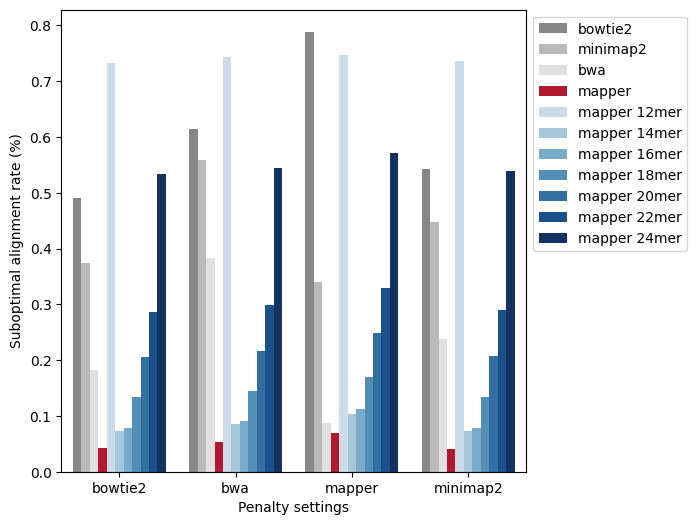

In [230]:
### penalty MG
# accuracy = (total_reads-reads_with_diff + reads_lowest_penalty_tool)/total_reads, max(accuracy = 100%)
total_reads = 19002904/4
allsam = glob.glob('%s/*/am0230*.samcompare.withtagclean.txt'%(folder))
allsam.sort()
print(allsam)
allscore = pd.DataFrame()
for samfile in allsam:
    tool = os.path.split(samfile)[-1].split('.samcompare.withtag')[0].split('.')[-1]
    score_sum,ymin = compute_accuracy(samfile,tool,total_reads)
    score_sum['penalty'] = tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    allscore = allscore.append(score_sum)
toolset1 = ['bowtie2','bwa','minimap2','mapper',
                         'mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']

legend_order = ['bowtie2','minimap2','bwa','mapper','mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']
allscore['sub'] = 100 - allscore['accuracy']
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6, 6))
allscoresub = allscore[allscore['tool'].isin(toolset1)]
allscoresub['tool'] = [x.replace('mapper (noancestor)','mapper') for x in allscoresub['tool']]
sns.barplot(x='penalty', y='sub', data=allscoresub,ax=axs,hue = 'tool',palette=palette_set,
            hue_order = legend_order,
                 dodge=True)
axs.set_ylabel('Suboptimal alignment rate (%)') 
axs.set_xlabel('Penalty settings') 
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
plt.savefig('%s/am0230_allclean.pdf'%(folder),bbox_inches='tight')


In [231]:
allscoresub['inaccuracy'] = 100 - allscoresub['accuracy']
allscoresub[allscoresub['penalty']=='bowtie2']

,tool,value,accuracy,penalty,sub,inaccuracy
0,bowtie2,1304929,99.509591,bowtie2,0.490409,0.490409
1,bwa,1319551,99.817375,bowtie2,0.182625,0.182625
2,minimap2,1310464,99.626099,bowtie2,0.373901,0.373901
3,mapper,1326244,99.958259,bowtie2,0.041741,0.041741
4,mapper 12mer,1293400,99.266912,bowtie2,0.733088,0.733088
5,mapper 14mer,1324717,99.926117,bowtie2,0.073883,0.073883
6,mapper 16mer,1324489,99.921317,bowtie2,0.078683,0.078683
7,mapper 18mer,1321900,99.866820,bowtie2,0.133180,0.133180
8,mapper 20mer,1318461,99.794431,bowtie2,0.205569,0.205569
9,mapper 22mer,1314620,99.713581,bowtie2,0.286419,0.286419


['SNP_model_penalty/bowtie/am0230_all.fastq_am0230.fasta.bowtie.samcompare.withtag.txt', 'SNP_model_penalty/bwa/am0230_all.fastq_am0230.fasta.bwa.samcompare.withtag.txt', 'SNP_model_penalty/mapper/am0230_all.fastq_am0230.fasta.mapper.samcompare.withtag.txt', 'SNP_model_penalty/minimap/am0230_all.fastq_am0230.fasta.minimap.samcompare.withtag.txt']
bowtie reads no diff = 0.7199663798754127 3420363.0 reads with diff= 0.28003362012458727 1330363
bwa reads no diff = 0.7196036984662976 3418640.0 reads with diff= 0.28039630153370243 1332086
mapper reads no diff = 0.7195317094692474 3418298.0 reads with diff= 0.28046829053075256 1332428
minimap reads no diff = 0.719544970600283 3418361.0 reads with diff= 0.280455029399717 1332365


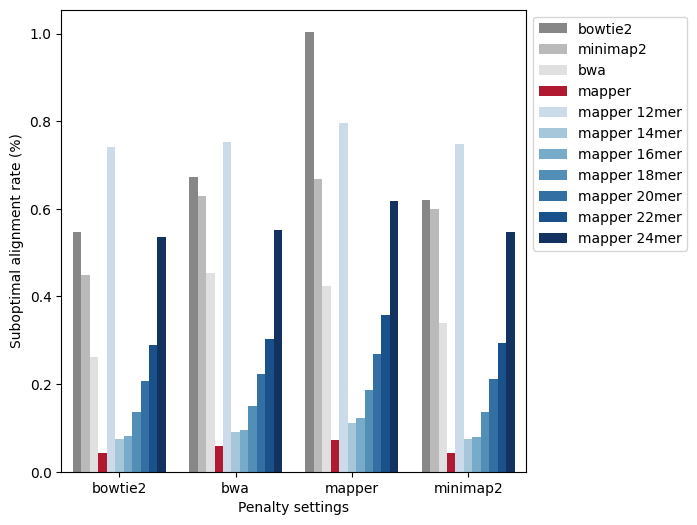

In [233]:
### penalty MG
# accuracy = (total_reads-reads_with_diff + reads_lowest_penalty_tool)/total_reads, max(accuracy = 100%)
total_reads = 19002904/4
allsam = glob.glob('%s/*/am0230*.samcompare.withtag.txt'%(folder))
allsam.sort()
print(allsam)
allscore = pd.DataFrame()
for samfile in allsam:
    tool = os.path.split(samfile)[-1].split('.samcompare.withtag.txt')[0].split('.')[-1]
    score_sum,ymin = compute_accuracy(samfile,tool,total_reads)
    score_sum['penalty'] = tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    allscore = allscore.append(score_sum)
toolset1 = ['bowtie2','bwa','minimap2','mapper',
                         'mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']

legend_order = ['bowtie2','minimap2','bwa','mapper','mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']
allscore['sub'] = 100 - allscore['accuracy']
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6, 6))
allscoresub = allscore[allscore['tool'].isin(toolset1)]
allscoresub['tool'] = [x.replace('mapper (noancestor)','mapper') for x in allscoresub['tool']]
sns.barplot(x='penalty', y='sub', data=allscoresub,ax=axs,hue = 'tool',palette=palette_set,
            hue_order = legend_order,
                 dodge=True)
axs.set_ylabel('Suboptimal alignment rate (%)') 
axs.set_xlabel('Penalty settings') 
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
plt.savefig('%s/am0230_all1.pdf'%(folder),bbox_inches='tight')


In [1]:
### penalty WGS
# accuracy = (total_reads-reads_with_diff + reads_lowest_penalty_tool)/total_reads, max(accuracy = 100%)
total_reads = 4750726 # PaDi
allsam = glob.glob('%s/*/am_PaDi*.samcompare.withtagclean.txt'%(folder))
allsam.sort()
print(allsam)
allscore = pd.DataFrame()
for samfile in allsam:
    tool = os.path.split(samfile)[-1].split('.samcompare.withtag')[0].split('.')[-1]
    score_sum,ymin = compute_accuracy(samfile,tool,total_reads)
    score_sum['penalty'] = tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    allscore = allscore.append(score_sum)
toolset1 = ['bowtie2','bwa','minimap2','mapper',
                         'mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']

legend_order = ['bowtie2','minimap2','bwa','mapper','mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']
allscore['sub'] = 100 - allscore['accuracy']
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6, 6))
allscoresub = allscore[allscore['tool'].isin(toolset1)]
allscoresub['tool'] = [x.replace('mapper (noancestor)','mapper') for x in allscoresub['tool']]
sns.barplot(x='penalty', y='sub', data=allscoresub,ax=axs,hue = 'tool',palette=palette_set,
            hue_order = legend_order,
                 dodge=True)
axs.set_ylabel('Suboptimal alignment rate (%)') 
axs.set_xlabel('Penalty settings') 
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
plt.savefig('%s/am_PaDi_allclean.pdf'%(folder),bbox_inches='tight')


In [4]:
allscoresub['inaccuracy'] = 100 - allscoresub['accuracy']
allscoresub[allscoresub['penalty']=='bowtie2']

,tool,value,accuracy,penalty,sub,inaccuracy
0,bowtie2,2356017,99.933400,bowtie2,0.066600,0.066600
1,bwa,2358291,99.981266,bowtie2,0.018734,0.018734
2,minimap2,2356475,99.943040,bowtie2,0.056960,0.056960
3,mapper,2359039,99.997011,bowtie2,0.002989,0.002989
4,mapper 12mer,2359021,99.996632,bowtie2,0.003368,0.003368
5,mapper 14mer,2359011,99.996422,bowtie2,0.003578,0.003578
6,mapper 16mer,2358943,99.994990,bowtie2,0.005010,0.005010
7,mapper 18mer,2358658,99.988991,bowtie2,0.011009,0.011009
8,mapper 20mer,2358233,99.980045,bowtie2,0.019955,0.019955
9,mapper 22mer,2357910,99.973246,bowtie2,0.026754,0.026754


['SNP_model_penalty/bowtie/am_PaDi_g0001_all.fastq_am_PaDi_g0001.fasta.bowtie.samcompare.withtag.txt', 'SNP_model_penalty/bwa/am_PaDi_g0001_all.fastq_am_PaDi_g0001.fasta.bwa.samcompare.withtag.txt', 'SNP_model_penalty/mapper/am_PaDi_g0001_all.fastq_am_PaDi_g0001.fasta.mapper.samcompare.withtag.txt', 'SNP_model_penalty/minimap/am_PaDi_g0001_all.fastq_am_PaDi_g0001.fasta.minimap.samcompare.withtag.txt']
bowtie reads no diff = 0.5014507256364606 2382255 reads with diff= 0.4985492743635394 2368471
bwa reads no diff = 0.5009857440736426 2380046 reads with diff= 0.49901425592635734 2370680
mapper reads no diff = 0.5015732332279319 2382837 reads with diff= 0.4984267667720681 2367889
minimap reads no diff = 0.5011520344469456 2380836 reads with diff= 0.49884796555305444 2369890


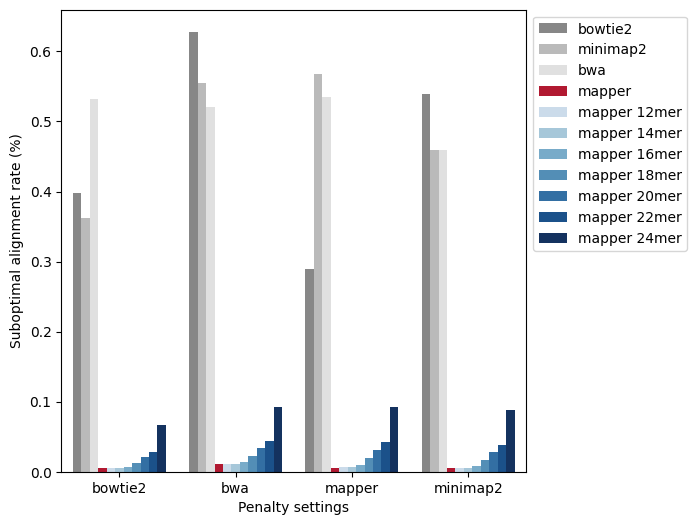

In [237]:
### penalty WGS
# accuracy = (total_reads-reads_with_diff + reads_lowest_penalty_tool)/total_reads, max(accuracy = 100%)
total_reads = 4750726 # PaDi
allsam = glob.glob('%s/*/am_PaDi*.samcompare.withtag.txt'%(folder))
allsam.sort()
print(allsam)
allscore = pd.DataFrame()
for samfile in allsam:
    tool = os.path.split(samfile)[-1].split('.samcompare.withtag.txt')[0].split('.')[-1]
    score_sum,ymin = compute_accuracy(samfile,tool,total_reads)
    score_sum['penalty'] = tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    allscore = allscore.append(score_sum)
toolset1 = ['bowtie2','bwa','minimap2','mapper',
                         'mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']

legend_order = ['bowtie2','minimap2','bwa','mapper','mapper 12mer','mapper 14mer','mapper 16mer',
                        'mapper 18mer','mapper 20mer','mapper 22mer','mapper 24mer']
allscore['sub'] = 100 - allscore['accuracy']
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6, 6))
allscoresub = allscore[allscore['tool'].isin(toolset1)]
allscoresub['tool'] = [x.replace('mapper (noancestor)','mapper') for x in allscoresub['tool']]
sns.barplot(x='penalty', y='sub', data=allscoresub,ax=axs,hue = 'tool',palette=palette_set,
            hue_order = legend_order,
                 dodge=True)
axs.set_ylabel('Suboptimal alignment rate (%)') 
axs.set_xlabel('Penalty settings') 
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
plt.savefig('%s/am_PaDi_all1.pdf'%(folder),bbox_inches='tight')


In [406]:
# load
# run samtopenaltydetails2.py
samplename = 'am_PaDi_g0001'# 'am_PaDi_g0001'#'Bactor'#'am0230'

max_penalty = 0.6
score = pd.read_csv('SNP_model_penalty/bowtie/%s_all.fastq_%s.fasta.bowtie.samcompare.withtagclean.txt'%(samplename,samplename),
                    sep='\t')
print(score.shape)
score['readID']=score['readID'] + score['read']
score = score.drop_duplicates('readID') # remove short reads of the same ID, partial alignment by minimap and bwa
print(score.shape)
score['sumtools'] = score['bowtie'] + score['mapper'] + score['minimap'] + score['bwa'] 
score = score[(score['sumtools']!=4*score['mapper'])|
             (score['sumtools']!=4*score['bowtie'])|
             (score['sumtools']!=4*score['minimap'])|
             (score['sumtools']!=4*score['bwa'])]
score.loc[score['tag2'].isna(),'tag2']='Others'
print(score.shape)
score.head()
#


(4678935, 26)
(4678935, 26)
(12023, 27)


,readID,read,mapper,bowtie,bwa,minimap,mapper.kmer12,mapper.kmer14,mapper.kmer16,mapper.kmer18,...,tagmapper.kmer12,tagmapper.kmer14,tagmapper.kmer16,tagmapper.kmer18,tagmapper.kmer20,tagmapper.kmer22,tagmapper.kmer24,tag2,minpenalty,sumtools
585,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13177...,GCTCTCATCAAGCGCAGCCTTTGCTGGTTTCAAAACTCTTTCCTCA...,10,50,10,10,10,10,10,10,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongIn,10,80
602,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13264...,GAATAAGAACGAAGATTTAAGGAGAATCAAGGCCGGAGCACAAACT...,1,1,6,1,1,1,1,1,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,Others,1,9
1110,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:17603...,GAATTATTGAAAGCGAAAGATTTCACTCGTCAGTCTCCGAAAGATT...,12,1000,12,12,12,12,12,12,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,Others,12,1036
1471,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:20244...,GATCTATTCTGTCTTTTCCGTTCTTGTCCTTGTATTTGTCCGCAGG...,11,34,11,11,11,11,11,11,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongIn,11,67
2085,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:25459...,TGGATTTTGCGAACCGATAGAGAAATCATAATAGACAACCGCTTTT...,24,1000,24,1000,24,24,24,24,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,alignmentmissed,Others,24,2048


In [411]:
scoresum = pd.DataFrame(score.groupby(['tag2'])['tag2'].count())
scoresum.columns = ['count']
scoresum.reset_index(inplace=True)
scoresum.sort_values('count')

,tag2,count
5,RightInWrongSoftWrongIn,1
13,WrongSoftWrongIn,1
9,RightSoftRightInWrongSoft,5
11,WrongIn,19
7,RightSoftRightIn,22
4,RightInWrongSoft,41
8,RightSoftRightInWrongIn,44
12,WrongSoft,56
2,RightIn,324
3,RightInWrongIn,362


In [412]:
# check kmer
score2sub = score
print(score2sub[score2sub['mapper']==1000].shape,
      score2sub[score2sub['bowtie']==1000].shape,
      score2sub[score2sub['bwa']==1000].shape,
      score2sub[score2sub['minimap']==1000].shape,
      score2sub[score2sub['mapper.kmer12']==1000].shape,
      score2sub[score2sub['mapper.kmer18']==1000].shape,
      score2sub[score2sub['mapper.kmer24']==1000].shape,
     )
score2sub[score2sub['mapper']==1000].head()



(26, 27) (4893, 27) (681, 27) (6535, 27) (45, 27) (919, 27) (3639, 27)


,readID,read,mapper,bowtie,bwa,minimap,mapper.kmer12,mapper.kmer14,mapper.kmer16,mapper.kmer18,...,tagmapper.kmer12,tagmapper.kmer14,tagmapper.kmer16,tagmapper.kmer18,tagmapper.kmer20,tagmapper.kmer22,tagmapper.kmer24,tag2,minpenalty,sumtools
4678909,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:23210:2869:...,CCCTTGTTCAGTATGAAGAAGAACCGGGGGTCTGCGTGTTCCGTTG...,1000,18,18,1000,18,18,18,18,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,alignmentmissed,Others,18,2036
4678910,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:12202:5647:...,TTCTGGGGGGAATGCCCATCCTATACCTAAAAAACTAATTTTGATC...,1000,24,24,1000,24,24,24,24,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,alignmentmissed,alignmentmissed,Others,24,2048
4678911,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:13104:6423:...,GATTTTTAACCCAATAAGGAGACATTATCTCTCCATAATAAACTTT...,1000,1000,18,1000,18,18,18,18,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,Others,18,3018
4678912,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:22209:16209...,GCGTGATGGTGCGCTTCGATGATGTGGAATGGAGCAGGTTCCTGAC...,1000,1000,62,62,1000,1000,1000,1000,...,alignmentmissed,alignmentmissed,alignmentmissed,alignmentmissed,alignmentmissed,alignmentmissed,alignmentmissed,RightSoft,62,2124
4678913,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:4:11506:9328:...,ACGTCCATGTGTCACATATGGTGATACGATAATCCCTTATGGCATT...,1000,1000,42,42,42,42,42,42,...,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,>=5 SNPs,42,2084


In [414]:
# check all causes
score2sub = score
penaltykmer = pd.DataFrame(
    {'readID': score2sub['readID'],
    'bowtie' : '',
    'bwa' :'',
    'minimap' : '',
    'mapper' : ''}
)
toolkmerset = {
    'mapper.kmer12':12,
    'mapper.kmer18':18,
    'mapper.kmer24':24,

}
for i in score2sub.index:
    readID = score2sub.loc[i,'readID']
    for tool in ['bowtie','bwa','minimap','mapper']:
        tag = ''
        if score2sub.loc[i,tool] == 1000:
            # no alignment
            toolkmer = [score2sub.loc[i,'mapper.kmer12'],
                        score2sub.loc[i,'mapper.kmer18'],
                        score2sub.loc[i,'mapper.kmer24']
                       ]
            if 1000 in toolkmer:
                if  toolkmer[0]!= 1000:
                    tag = 'k-mer too long'
                elif toolkmer[-1]!= 1000:
                    tag = 'k-mer too short'
                elif toolkmer[1]!= 1000:
                    tag = 'k-mer suboptimal'
                penaltykmer.loc[penaltykmer['readID']==readID,
                                    tool] = tag
        else:
            minscore = score2sub.loc[i,'minpenalty']
            toolscore = score2sub.loc[i,tool]
            if toolscore > minscore:
                # suboptimal alignment
                toolkmer = [score2sub.loc[i,'mapper.kmer12'],
                        score2sub.loc[i,'mapper.kmer18'],
                        score2sub.loc[i,'mapper.kmer24']
                       ]
                if toolscore in toolkmer:
                    if toolkmer[0]< toolscore:
                        tag = 'k-mer too long'
                    elif toolkmer[-1]< toolscore:
                        tag = 'k-mer too short'
                    elif toolkmer[1]< toolscore:
                        tag = 'k-mer suboptimal'
                    penaltykmer.loc[penaltykmer['readID']==readID,
                                        tool] = tag

penaltykmer.head()


,readID,bowtie,bwa,minimap,mapper
585,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13177...,,,,
602,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13264...,,,,
1110,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:17603...,,,,
1471,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:20244...,,,,
2085,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:25459...,k-mer too long,,k-mer too long,


In [416]:
score2sub = score2sub.merge(penaltykmer,
                                       left_on = 'readID',right_on = 'readID',how = 'left')
score2sub.head()

,readID,read,mapper_x,bowtie_x,bwa_x,minimap_x,mapper.kmer12,mapper.kmer14,mapper.kmer16,mapper.kmer18,...,tagmapper.kmer20,tagmapper.kmer22,tagmapper.kmer24,tag2,minpenalty,sumtools,bowtie_y,bwa_y,minimap_y,mapper_y
0,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13177...,GCTCTCATCAAGCGCAGCCTTTGCTGGTTTCAAAACTCTTTCCTCA...,10,50,10,10,10,10,10,10,...,bestalignment,bestalignment,bestalignment,RightSoftWrongIn,10,80,,,,
1,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:13264...,GAATAAGAACGAAGATTTAAGGAGAATCAAGGCCGGAGCACAAACT...,1,1,6,1,1,1,1,1,...,bestalignment,bestalignment,bestalignment,Others,1,9,,,,
2,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:17603...,GAATTATTGAAAGCGAAAGATTTCACTCGTCAGTCTCCGAAAGATT...,12,1000,12,12,12,12,12,12,...,bestalignment,bestalignment,bestalignment,Others,12,1036,,,,
3,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:20244...,GATCTATTCTGTCTTTTCCGTTCTTGTCCTTGTATTTGTCCGCAGG...,11,34,11,11,11,11,11,11,...,bestalignment,bestalignment,bestalignment,RightSoftWrongIn,11,67,,,,
4,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:25459...,TGGATTTTGCGAACCGATAGAGAAATCATAATAGACAACCGCTTTT...,24,1000,24,1000,24,24,24,24,...,bestalignment,bestalignment,alignmentmissed,Others,24,2048,k-mer too long,,k-mer too long,


In [451]:
score2subtoolall = pd.DataFrame()
for tool in ['bowtie','minimap','bwa','mapper']:
    score2subbowtie = score2sub[score2sub['%s_x'%(tool)]>score2sub['minpenalty']]
    score2subbowtie.loc[score2subbowtie['%s_y'%(tool)]!='','tag2']=score2subbowtie.loc[score2subbowtie['%s_y'%(tool)]!='','%s_y'%(tool)]
    score2subbowtie['tag2'] = score2subbowtie['tag2'].replace('WrongSoftWrongIn','WrongSoft').replace(
        'RightSoftRightIn','RightIn').replace(
        'RightInWrongSoft','Indels missing').replace(
        'RightSoft','Soft clips missing').replace(
        'WrongSoft','Misassigned soft clips').replace(
        'RightSoftWrongIn','Soft clips missing').replace(
        'RightSoftWrongSoft','Misassigned soft clips').replace(
        'RightInWrongIn','Indels missing').replace(
        'RightIn','Indels missing').replace(
        'RightInWrongSoftWrongIn','Indels missing').replace(
        'RightSoftRightInWrongIn','Indels missing').replace(
        'RightSoftWrongSoftWrongIn','Soft clips missing').replace(
        'RightSoftRightInWrongSoftWrongIn','Indels missing').replace(
        'RightSoftRightInWrongSoft','Indels missing').replace(
        'WrongIn','Others')
    score2subtool = pd.DataFrame(score2subbowtie.groupby('tag2')['tag2'].count())
    score2subtool.columns=['count']
    score2subtool.reset_index(inplace=True)
    score2subtool['tool']=tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    score2subtool['total'] = score2subbowtie.shape[0]
    score2subtoolall = score2subtoolall.append(score2subtool)
score2subtoolall.sort_values('count')



,tag2,count,tool,total
4,k-mer suboptimal,1,mapper,259
0,>=5 SNPs,1,mapper,259
6,k-mer too short,2,bowtie2,7219
7,k-mer too short,4,bwa,1894
7,k-mer too short,6,minimap2,7335
5,k-mer suboptimal,6,bwa,1894
2,Misassigned soft clips,6,minimap2,7335
4,k-mer suboptimal,7,bowtie2,7219
5,k-mer suboptimal,8,minimap2,7335
2,Others,10,mapper,259


In [418]:
score2subtoolall[score2subtoolall['tag2'].isin([
    'k-mer suboptimal', 'k-mer too long',
       'k-mer too short'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     2086
bwa          629
mapper        39
minimap2    3394
Name: count, dtype: int64

In [419]:
score2subtoolall[score2subtoolall['tag2'].isin([
    'Indels missing', 'Misassigned soft clips',
       'Soft clips missing'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     3236
bwa          804
mapper       209
minimap2     620
Name: count, dtype: int64

In [420]:
score2subtoolall[score2subtoolall['tag2'].isin([
    '>=5 SNPs'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     558
bwa          53
mapper        1
minimap2    420
Name: count, dtype: int64

In [421]:
score2subtoolall['tag2'].unique()

array(['>=5 SNPs', 'Indels missing', 'Others', 'Soft clips missing',
       'k-mer suboptimal', 'k-mer too long', 'k-mer too short',
       'Misassigned soft clips'], dtype=object)

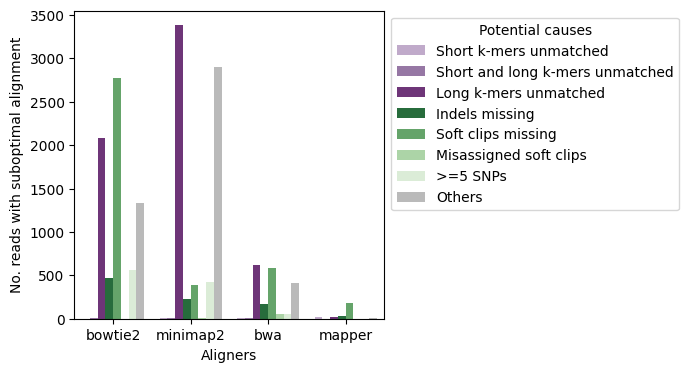

In [425]:
score2subtoolall['tag2'] = [
    x.replace('k-mer too short','Short k-mers unmatched').replace(
        'k-mer too long','Long k-mers unmatched').replace(
        'k-mer suboptimal','Short and long k-mers unmatched') for x in score2subtoolall['tag2'] 
]
palette_set = {
    'Short k-mers unmatched':'#c2a5cf',
    'Long k-mers unmatched':'#762a83',
     'Short and long k-mers unmatched':'#9970ab',
    'Soft clips missing':'#5aae61',
    'Indels missing':'#1b7837',
    'Misassigned soft clips':'#a6dba0',
    '>=5 SNPs':'#d9f0d3',
    'Others':'#bababa',

}
legend_order = [ 'Short k-mers unmatched','Short and long k-mers unmatched', 'Long k-mers unmatched', 
                'Indels missing', 
                'Soft clips missing','Misassigned soft clips', '>=5 SNPs',
                'Others']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(4, 4))
sns.barplot(data = score2subtoolall,
            x='tool',y='count',hue='tag2',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('Aligners') 
axs.set_ylabel('No. reads with suboptimal alignment')
plt.sca(axs)
plt.legend(title = 'Potential causes', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('%s_bowtie_allwrongalignment.pdf'%(samplename),bbox_inches='tight')


In [426]:
score2subtoolall = pd.DataFrame(
{
        'tool':['bowtie','minimap','bwa','mapper'],
        'count':0
    }
)
for tool in ['bowtie','minimap','bwa','mapper']:
    score2subbowtie = score2sub[score2sub['%s_x'%(tool)]>score2sub['minpenalty']]
    score2subtoolall.loc[score2subtoolall['tool']==tool,'count']= score2subbowtie.shape[0]
    score2subtoolall.loc[score2subtoolall['tool']==tool,'tool']= tool.replace('bowtie','bowtie2').replace('minimap','minimap2')

score2subtoolall.tail()


,tool,count
0,bowtie2,7219
1,minimap2,7335
2,bwa,1894
3,mapper,259


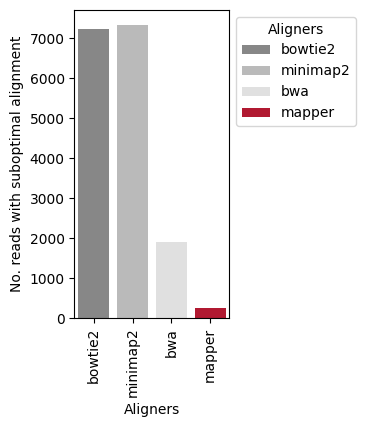

In [427]:
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
        'bowtie2 (15mer)':'#0571b0','minimap2 (10mer)':'#92c5de',
    'mapper (no ancestor)':'#ca0020','mapper.kmer12':'#ca0020',
    'mapper.kmer18':'#ca0020','mapper.kmer24':'#ca0020'}

legend_order = [ 'bowtie2', 'minimap2',
                'bwa', 
                'mapper']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2,4))
sns.barplot(data = score2subtoolall,
            x='tool',y='count',hue='tool',palette=palette_set,hue_order = legend_order,dodge=False)
axs.set_xlabel('Aligners') 
axs.set_ylabel('No. reads with suboptimal alignment')
plt.sca(axs)
plt.xticks(rotation=90)

plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('%s_bowtie_allwrongalignmentall.pdf'%(samplename),bbox_inches='tight')


In [452]:
score2subtoolall = pd.DataFrame()
for tool,tooltag in zip(['bowtie','minimap','bwa','mapper'],['tagbowtie','tagminimap','tagbwa','tagmapper']):
    score2subbowtie = score2sub[score2sub['%s_x'%(tool)]>score2sub['minpenalty']]
    score2subbowtie['tag1'] = score2subbowtie[tooltag].replace('alignmentmissed',
                                                               'Failed to align').replace('diffCHR',
                                                               'Wrong sites').replace('sameCHRdiffPOS',
                                                               'Wrong sites').replace('sameCHRclosePOS',
                                                               'Close sites').replace('sameCHRsamePOS',
                                                               'Same sites')
    score2subtool = pd.DataFrame(score2subbowtie.groupby('tag1')['tag1'].count())
    score2subtool.columns=['count']
    score2subtool.reset_index(inplace=True)
    score2subtool['tool']=tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    score2subtoolall = score2subtoolall.append(score2subtool)
score2subtoolall


,tag1,count,tool
0,Close sites,251,bowtie2
1,Failed to align,4893,bowtie2
2,Same sites,1758,bowtie2
3,Wrong sites,317,bowtie2
0,Close sites,17,minimap2
1,Failed to align,6535,minimap2
2,Same sites,317,minimap2
3,Wrong sites,466,minimap2
0,Close sites,13,bwa
1,Failed to align,681,bwa


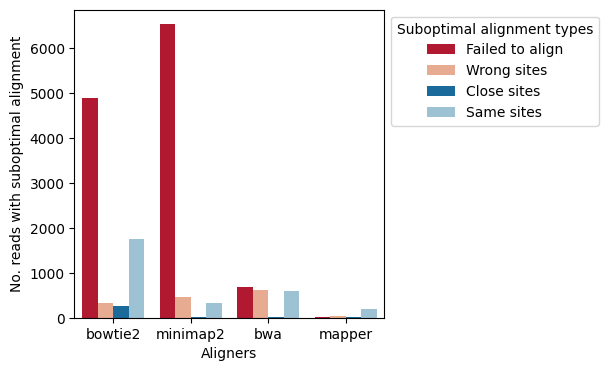

In [431]:
palette_set = {
    'Failed to align':'#ca0020',
    'Wrong sites':'#f4a582',
    'Close sites':'#0571b0',
    'Same sites':'#92c5de',

}
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(4, 4))
legend_order = [ 'Failed to align', 'Wrong sites',
                'Close sites', 
                'Same sites']

sns.barplot(data = score2subtoolall,
            x='tool',y='count',hue='tag1',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('Aligners') 
axs.set_ylabel('No. reads with suboptimal alignment')
plt.sca(axs)
plt.legend(title = 'Suboptimal alignment types',bbox_to_anchor=(1.0, 1.0))
plt.savefig('%s_bowtie_allwrongalignment2.pdf'%(samplename),bbox_inches='tight')


In [432]:
score2subbowtie = score2sub[score2sub['%s_x'%('minimap')]==1000]
score2subbowtie.head()


,readID,read,mapper_x,bowtie_x,bwa_x,minimap_x,mapper.kmer12,mapper.kmer14,mapper.kmer16,mapper.kmer18,...,tagmapper.kmer20,tagmapper.kmer22,tagmapper.kmer24,tag2,minpenalty,sumtools,bowtie_y,bwa_y,minimap_y,mapper_y
4,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21207:25459...,TGGATTTTGCGAACCGATAGAGAAATCATAATAGACAACCGCTTTT...,24,1000,24,1000,24,24,24,24,...,bestalignment,bestalignment,alignmentmissed,Others,24,2048,k-mer too long,,k-mer too long,
9,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21202:22494...,GCCAGATGCTGTGCGGAATAGACCGACCGGTGCTGTCCTCCCGTAC...,60,60,60,1000,60,60,60,60,...,bestalignment,bestalignment,bestalignment,>=5 SNPs,60,1180,,,,
11,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13210:24238...,GTTAACACCAACGATGGTCTGAACAACAGAGTAGATACGAGCCTGA...,54,54,54,1000,54,54,54,54,...,bestalignment,alignmentmissed,alignmentmissed,>=5 SNPs,54,1162,,,k-mer too long,
16,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13208:14689...,CCTCGGACTGGAGACTTAAATTTTATATATGTTTGAAAATAAAACA...,24,1000,1000,1000,24,24,1000,1000,...,alignmentmissed,alignmentmissed,alignmentmissed,Others,24,3024,k-mer too long,k-mer too long,k-mer too long,
17,SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13208:14992...,ATACAGCATAGGAAATAAAGTTGAAACCTCACGTCTCATCGAATTT...,12,12,12,1000,12,12,12,12,...,bestalignment,alignmentmissed,alignmentmissed,Others,12,1036,,,k-mer too long,


In [434]:
# no alignment + wrong sites only
score2subtoolall = pd.DataFrame()
score2subtoolall2 = pd.DataFrame(
{
        'tool':['bowtie','minimap','bwa','mapper'],
        'count':0
    }
)
for tool,tooltag in zip(['bowtie','minimap','bwa','mapper'],['tagbowtie','tagminimap','tagbwa','tagmapper']):
    score2subbowtie = score2sub[score2sub['%s_x'%(tool)]>score2sub['minpenalty']]
    score2subbowtie['tag1'] = score2subbowtie[tooltag].replace('alignmentmissed',
                                                               'Failed to align').replace('diffCHR',
                                                               'Wrong sites').replace('sameCHRdiffPOS',
                                                               'Wrong sites').replace('sameCHRclosePOS',
                                                               'Close sites').replace('sameCHRsamePOS',
                                                               'Same sites')
    score2subbowtie = score2subbowtie[score2subbowtie['tag1'].isin(['Failed to align','Wrong sites'])]
    print(score2subbowtie.shape)
    score2subtoolall2.loc[score2subtoolall2['tool']==tool,'count']= score2subbowtie.shape[0]
    score2subtoolall2.loc[score2subtoolall2['tool']==tool,'tool']= tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
#     score2subbowtie = score2sub[score2sub['%s_x'%(tool)]==1000]
    score2subbowtie.loc[score2subbowtie['%s_y'%(tool)]!='','tag2']=score2subbowtie.loc[score2subbowtie['%s_y'%(tool)]!='','%s_y'%(tool)]
    score2subbowtie['tag2'] = score2subbowtie['tag2'].replace('WrongSoftWrongIn','WrongSoft').replace(
        'RightSoftRightIn','RightIn').replace(
        'RightInWrongSoft','Indels missing').replace(
        'RightSoft','Soft clips missing').replace(
        'WrongSoft','Misassigned soft clips').replace(
        'RightSoftWrongIn','Soft clips missing').replace(
        'RightSoftWrongSoft','Misassigned soft clips').replace(
        'RightInWrongIn','Indels missing').replace(
        'RightIn','Indels missing').replace(
        'RightInWrongSoftWrongIn','Indels missing').replace(
        'RightSoftRightInWrongIn','Indels missing').replace(
        'RightSoftWrongSoftWrongIn','Soft clips missing').replace(
        'RightSoftRightInWrongSoftWrongIn','Indels missing').replace(
        'RightSoftRightInWrongSoft','Indels missing').replace(
        'WrongIn','Others')
    score2subtool = pd.DataFrame(score2subbowtie.groupby('tag2')['tag2'].count())
    score2subtool.columns=['count']
    score2subtool.reset_index(inplace=True)
    score2subtool['tool']=tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
    score2subtoolall = score2subtoolall.append(score2subtool)
score2subtoolall.sort_values('count')


(5210, 32)
(7001, 32)
(1291, 32)
(62, 32)


,tag2,count,tool
0,>=5 SNPs,1,mapper
6,k-mer too short,2,bowtie2
1,Indels missing,4,mapper
7,k-mer too short,4,bwa
7,k-mer too short,6,minimap2
5,k-mer suboptimal,6,bwa
2,Misassigned soft clips,6,minimap2
4,k-mer suboptimal,7,bowtie2
5,k-mer suboptimal,8,minimap2
2,Others,10,mapper


In [435]:
score2subtoolall[score2subtoolall['tag2'].isin([
    'k-mer suboptimal', 'k-mer too long',
       'k-mer too short'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     2086
bwa          629
mapper        33
minimap2    3394
Name: count, dtype: int64

In [436]:
score2subtoolall2.tail()


,tool,count
0,bowtie2,5210
1,minimap2,7001
2,bwa,1291
3,mapper,62


In [438]:
score2subtoolall[score2subtoolall['tag2'].isin([
    'Indels missing', 'Misassigned soft clips',
       'Soft clips missing'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     1227
bwa          209
mapper        18
minimap2     289
Name: count, dtype: int64

In [440]:

score2subtoolall[score2subtoolall['tag2'].isin([
    '>=5 SNPs'
])].sort_values(['tool']).groupby('tool')['count'].sum()

tool
bowtie2     558
bwa          53
mapper        1
minimap2    420
Name: count, dtype: int64

In [445]:
tagtocheck = 'k-mer too long'
list1 = score2sub[score2sub['%s_y'%('bowtie')]==tagtocheck][score2sub['%s_x'%('bowtie')]==1000]
list1 = list1[list1['%s_y'%('bwa')]==tagtocheck][list1['%s_x'%('bwa')]==1000]
list1 = list1[list1['%s_y'%('minimap')]==tagtocheck][list1['%s_x'%('minimap')]==1000]
list1 = list1[list1['%s_y'%('mapper')]==''][list1['%s_x'%('mapper')]!=1000]
badreadID = list(list1['readID'])
print(len(badreadID))
badreadID[:20]

555


['SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13208:14689:11095CCTCGGACTGGAGACTTAAATTTTATATATGTTTGAAAATAAAACAATGAAA',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13209:6644:7414ATCAAGATGACAACGAACTCACCCGAGTGTCGGAGCGTAACGCTGATGACGATTTGTTGCT',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:13210:1559:4424ATCCTCACGAGCCAACCAACCCATTGCGCTGCCTAATTCCATATCGTCCA',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21107:26072:4517CCTAGTGGATTTACCCGCCTACGAGGGATTTATATGAGAAGCCAACCTTCTTCGAGTGCTTCTCTTACAA',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:1:21205:15032:20384GGGAAGAAAACAAATCCGGAAAGAGAGTTACCCTCAAAAGCATTGAGGACATTG',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:12109:21025:13401ATATAGCCACAATCCATTACTACGCAATAAATGACGATTCCCGGTATTATAAAAAAAGGCGGTA',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:12105:20689:2612AAATGTATATGAAACCTTTTCTCAATTCAGTACTTTGTATGAGTATCCCCG',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:11304:26383:17364TCCCCCTTTCCAGCGTCCAATGAACAGATGGGTCAGCAACCGCTTGGCCTTTGCGTAACCATCAAAATGGCCG',
 'SL-NXA:HMCF2BGX3171213:HMCF2BGX3:2:12310:26699:11355ATAAATACACTATACTTTCAG

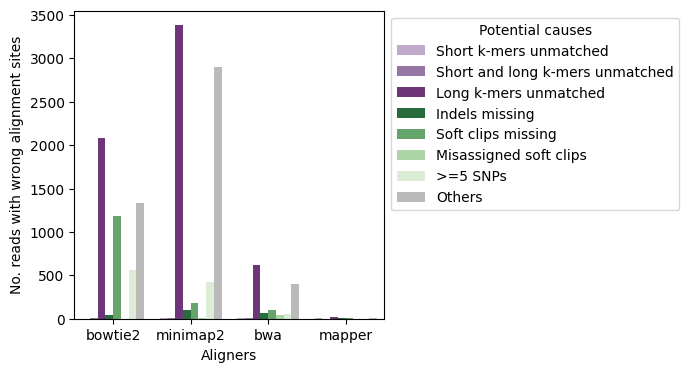

In [449]:
score2subtoolall['tag2'] = [
    x.replace('k-mer too short','Short k-mers unmatched').replace(
        'k-mer too long','Long k-mers unmatched').replace(
        'k-mer suboptimal','Short and long k-mers unmatched') for x in score2subtoolall['tag2'] 
]
palette_set = {
    'Short k-mers unmatched':'#c2a5cf',
    'Long k-mers unmatched':'#762a83',
     'Short and long k-mers unmatched':'#9970ab',
    'Soft clips missing':'#5aae61',
    'Indels missing':'#1b7837',
    'Misassigned soft clips':'#a6dba0',
    '>=5 SNPs':'#d9f0d3',
    'Others':'#bababa',

}
legend_order = [ 'Short k-mers unmatched','Short and long k-mers unmatched', 'Long k-mers unmatched', 
                'Indels missing', 
                'Soft clips missing','Misassigned soft clips', '>=5 SNPs',
                'Others']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(4, 4))
sns.barplot(data = score2subtoolall,
            x='tool',y='count',hue='tag2',palette=palette_set,hue_order = legend_order)
axs.set_xlabel('Aligners') 
axs.set_ylabel('No. reads with wrong alignment sites')
plt.sca(axs)
plt.legend(title = 'Potential causes', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('%s_bowtie_noalignment.pdf'%(samplename),bbox_inches='tight')


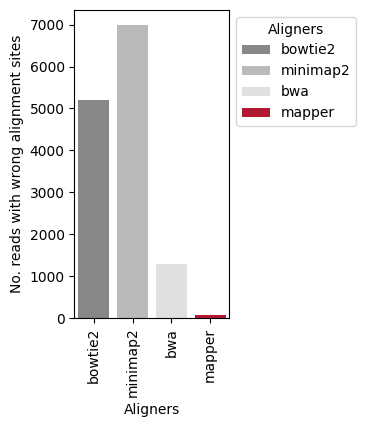

In [450]:
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
        'bowtie2 (15mer)':'#0571b0','minimap2 (10mer)':'#92c5de',
    'mapper (no ancestor)':'#ca0020','mapper.kmer12':'#ca0020',
    'mapper.kmer18':'#ca0020','mapper.kmer24':'#ca0020'}

legend_order = [ 'bowtie2', 'minimap2',
                'bwa', 
                'mapper']

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2,4))
sns.barplot(data = score2subtoolall2,
            x='tool',y='count',hue='tool',palette=palette_set,hue_order = legend_order,dodge=False)
axs.set_xlabel('Aligners') 
axs.set_ylabel('No. reads with wrong alignment sites')
plt.sca(axs)
plt.xticks(rotation=90)

plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
plt.savefig('%s_bowtie_noalignmentall.pdf'%(samplename),bbox_inches='tight')


In [113]:
## end